Entropic Regularization of Optimal Transport
============================================
This notebook is an extended version of a numerical tour by Gabriel Peyré and exposes the general methodology of regularizing the optimal transport (OT) linear program using entropy. Check out the [numerical tour website](https://www.numerical-tours.com/)  for many tutorials of this kind. A general reference for the algorithms seen in this notebook is the book [Computational Optimal Transport](https://optimaltransport.github.io/book/) by M. Cuturi and G. Peyré. It is organized as follows:
- I. Transport between point clouds
- II. Transport between histograms
- III. Wasserstein barycenters
- IV. Stabilization and acceleration

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

$$ \DeclareMathOperator{\KL}{KL}
\newcommand{\KLdiv}[2]{\KL\pa{#1 | #2}}
\newcommand{\KLproj}{\text{Proj}^{\tiny\KL}}
\renewcommand{\epsilon}{\varepsilon}
\def\ones{\mathbb{I}} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Entropic Regularization of Optimal Transport
--------------------------------------------
We consider two input histograms $a,b \in \Si_n$, where we denote the simplex in $\RR^n$
$$ \Si_n \eqdef \enscond{ a \in \RR_+^n }{ \sum_i a_i = 1 }.  $$
We consider the following discrete regularized transport
$$  W_\epsilon(a,b) \eqdef \umin{P \in U(a,b)} \dotp{C}{P} - \epsilon E(P).  $$
where the polytope of coupling is defined as
$$ U(a,b) \eqdef \enscond{P \in (\RR^+)^{n \times m}}{ P \ones_m = a, P^\top \ones_n = b },  $$
where $\ones_n \eqdef (1,\ldots,1)^\top \in \RR^n $,
and for $P \in \RR_+^{n \times m}$, we define its entropy as
$$ E(P) \eqdef -\sum_{i,j} P_{i,j} ( \log(P_{i,j}) - 1). $$


When $\epsilon=0$ one recovers the classical (discrete) optimal transport.
We refer to the monograph [Villani](#biblio) for more details about OT.
The idea of regularizing transport to allows for faster computation is
introduced in [Cuturi](#biblio).


Here the matrix $C \in (\RR^+)^{n \times m} $ defines the ground cost, i.e.
$C_{i,j}$ is the cost of moving mass from a bin indexed by $i$ to a bin indexed by $j$.


The regularized transportation problem can be re-written as a projection
$$ W_\epsilon(a,b) = \epsilon \umin{P \in U(a,b)} \KLdiv{P}{K}
	\qwhereq
	K_{i,j} \eqdef e^{ -\frac{C_{i,j}}{\epsilon} }  $$
of the Gibbs kernel $K$ according to the Kullback-Leibler divergence.
The Kullback-Leibler divergence between $P, K \in \RR_+^{n \times m}$ is
$$ \KLdiv{P}{K} \eqdef \sum_{i,j} P_{i,j} \pa{ \log\pa{ \frac{P_{i,j}}{K_{i,j}} } - 1} + 1. $$


This interpretation of regularized transport as a KL projection and its numerical
applications are detailed in [BenamouEtAl](#biblio).


Given a convex set $\Cc \subset \RR^N$, the projection according to the Kullback-Leiber divergence is defined as
$$ \KLproj_\Cc(\xi) = \uargmin{ \pi \in \Cc } \KLdiv{\pi}{\xi}. $$

Iterative Bregman Projection Algorithm
--------------------------------------
Given affine constraint sets $ (\Cc_1,\Cc_2) $, we aim at computing
$$   \KLproj_\Cc(K) \qwhereq \Cc = \Cc_1 \cap \Cc_2 $$
(this description can of course be extended to more than 2 sets). 

This can be achieved, starting by $P_0=K$, by iterating $\forall \ell \geq 0$, 
$$ P_{2\ell+1} =  \KLproj_{\Cc_1}(P_{2\ell}) 
 \qandq 
  P_{2\ell+2} =  \KLproj_{\Cc_2}(P_{2\ell+1}). $$

One can indeed show that $P_\ell \rightarrow \KLproj_\Cc(K)$.
We refer to [BauschkeLewis](#biblio) for more details about this
algorithm and its extension to compute the projection on the intersection of
convex sets (Dikstra algorithm).

Sinkhorn's Algorithm
-----------------------------------------------------------------------

A fundamental remark is that the optimality condition of the entropic regularized problem shows that the optimal coupling $P_\epsilon$ necessarily has the form 
$$P_\epsilon = \diag{u} K \diag{v}$$
where the Gibbs kernel is defined as
$$K \eqdef e^{-\frac{C}{\epsilon}}.$$

One thus needs to find two positive scaling vectors $u \in \RR_+^n$ and $v \in \RR_+^m$ such that the two following equality holds
$$P \ones  = u \odot (K v) = a 
\qandq
P^\top \ones  = v \odot (K^\top u) = b.$$

Sinkhorn's algorithm alternate between the resolution of these two equations, and reads
$$u \longleftarrow \frac{a}{K v} \qandq v \longleftarrow \frac{b}{K^\top u}.$$
This algorithm was shown to converge to a solution of the entropic regularized problem by [Sinkhorn](#biblio).

I. Transport Between Point Clouds
------------------------------
We first test the method for two input measures that are uniform measures
(i.e. constant histograms) supported on two point clouds
(that do not necessarily have the same size).


We thus first load two points clouds $x=(x_i)_{i=1}^{n}, y=(y_i)_{i=1}^{m}, $
where $x_i, y_i \in \RR^2$.


Number of points in each cloud, $N=(n,m)$.

In [2]:
N = [300,200]

Dimension of the clouds.

In [3]:
d = 2

Point cloud $x$, of $n$ points inside a square.

In [4]:
x = np.random.rand(2,N[0])-.5

Point cloud $y$, of $m$ points inside an anulus.

In [5]:
theta = 2*np.pi*np.random.rand(1,N[1])
r = .8 + .2*np.random.rand(1,N[1])
y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))

Shortcut for displaying point clouds.

In [6]:
plotp = lambda x,col: plt.scatter(x[0,:], x[1,:], s=200, edgecolors="k", c=col, linewidths=2)

Display of the two clouds.

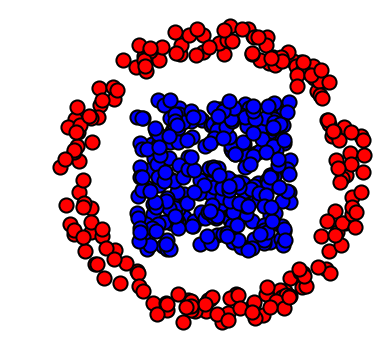

In [7]:
plt.figure(figsize=(6,6))

plotp(x, 'b')
plotp(y, 'r')

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

Cost matrix $C_{i,j} = \norm{x_i-y_j}^2$.

In [8]:
x2 = np.sum(x**2,0)
y2 = np.sum(y**2,0)
#C = np.tile(y2,(N[0],1)) + np.tile(x2[:,np.newaxis],(1,N[1])) - 2*np.dot(np.transpose(x),y)
C = (x[0,:].reshape(-1,1) - y[0,:].reshape(1,-1))**2 + (x[1,:].reshape(-1,1) - y[1,:].reshape(1,-1))**2

Target histograms $(a,b)$, here uniform histograms.

In [9]:
a = np.ones(N[0])/N[0]
b = np.ones(N[1])/N[1]

Regularization strength $\epsilon>0$.

In [10]:
epsilon = .01;

Gibbs Kernel $K$.

In [11]:
K = np.exp(-C/epsilon)

Initialization of $v=\ones_{m}$ ($u$ does not need to be
initialized).

In [12]:
v = np.ones(N[1])

One Sinkhorn iteration.

In [13]:
u = a / (np.dot(K,v))
v = b / (np.dot(np.transpose(K),u))

__Exercise 1__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$$ \norm{ P \ones - a }_1 \qandq \norm{ P^\top \ones - b } $$
(you need to think about how to compute these residuals from $(u,v)$ alone).
Display the violation of constraint error in log-plot.

$$P \ones  = u \odot (K v) = a 
\qandq
P^\top \ones  = v \odot (K^\top u) = b.$$
$$P_\epsilon = \diag{u} K \diag{v}$$

In [14]:
class Sinkhorn:
    
    def __init__(self, K, a, b, max_it=1000):
        self.K = K
        self.a = a
        self.b = b
        self.max_it = max_it
        self.v = np.ones(len(b))
        self.u = None
        self.a_err = []
        self.b_err = []
        
    def solve(self):
        conv = False
        it = 0
        while not conv:
            # step 1
            u_np1 = self.a / (np.dot(self.K, self.v))
            P = np.diag(u_np1).dot(self.K.dot(np.diag(self.v)))
            self.b_err.append(np.sum( np.abs( np.sum(P, axis=0) - self.b ) ))
            # step 2
            v_np1 = self.b / (np.dot(np.transpose(self.K),u_np1))
            P = np.diag(u_np1).dot(self.K.dot(np.diag(v_np1)))
            self.a_err.append(np.sum( np.abs( np.sum(P, axis=1) - self.a ) ))
            # total updates
            self.u, self.v = u_np1, v_np1
            it += 1
            conv = (it>self.max_it)
        self.P = P

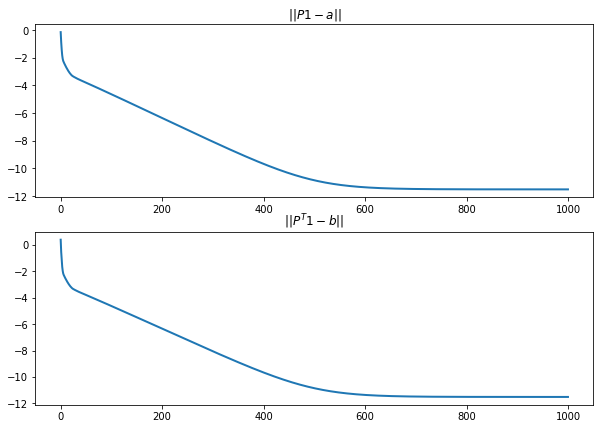

In [15]:
sinkhorn_0 = Sinkhorn(K, a, b)
sinkhorn_0.solve()

plt.figure(figsize = (10,7))

plt.subplot(2,1,1)
plt.title("$||P 1 - a||$")
plt.plot(np.log(np.asarray(sinkhorn_0.a_err) + 1e-5), linewidth = 2)

plt.subplot(2,1,2)
plt.title("$||P^T 1 - b||$")
plt.plot(np.log(np.asarray(sinkhorn_0.b_err) + 1e-5), linewidth = 2)

plt.show()

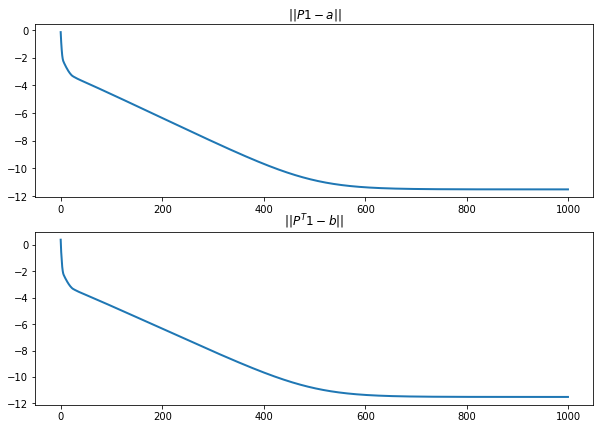

<Figure size 432x288 with 0 Axes>

In [16]:
run -i solutions/exo1

Compute the final matrix $P$.

In [17]:
P = np.dot(np.dot(np.diag(sinkhorn_0.u),K),np.diag(sinkhorn_0.v))

Display it.

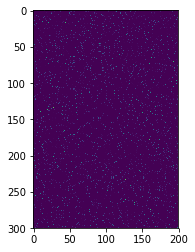

In [18]:
plt.imshow(P);

__Exercise 2__

Display the regularized transport solution for various values of $\epsilon$.
For a too small value of $\epsilon$, what do you observe ?

In [19]:
epsilons = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
sinkhorns = []
max_it = 500

for eps in epsilons:
    print("Processing epsilon={}...".format(eps))
    K = np.exp(-C/eps)
    sinkhorns.append(Sinkhorn(K, a, b, max_it=max_it))
    sinkhorns[-1].solve()

Processing epsilon=0.001...
Processing epsilon=0.005...
Processing epsilon=0.01...
Processing epsilon=0.05...
Processing epsilon=0.1...
Processing epsilon=0.5...


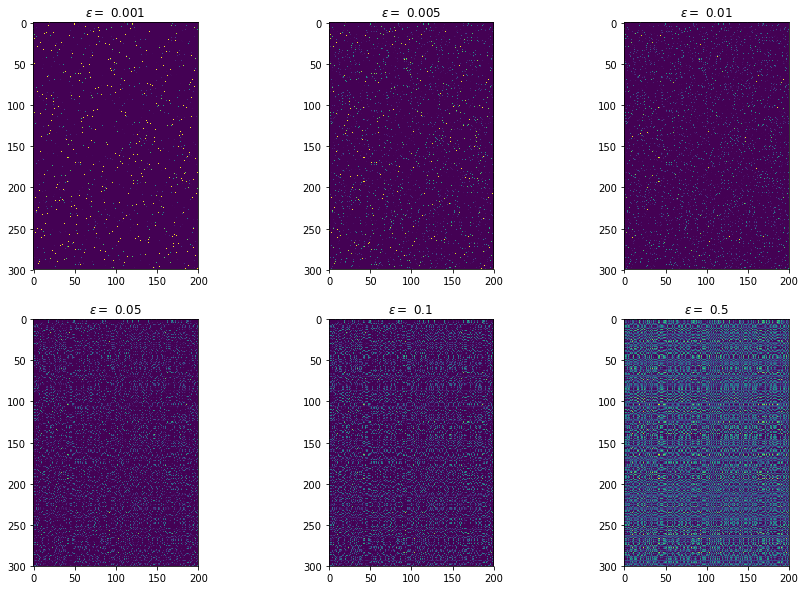

In [20]:
plt.figure(figsize = (15,10))

for k in range(len(sinkhorns)):
    plt.subplot(2,3,k+1)
    plt.imshow(np.clip(sinkhorns[k].P,0,np.min(1/np.asarray(N))*.3))
    plt.title("$\epsilon =$ {}".format(epsilons[k]))

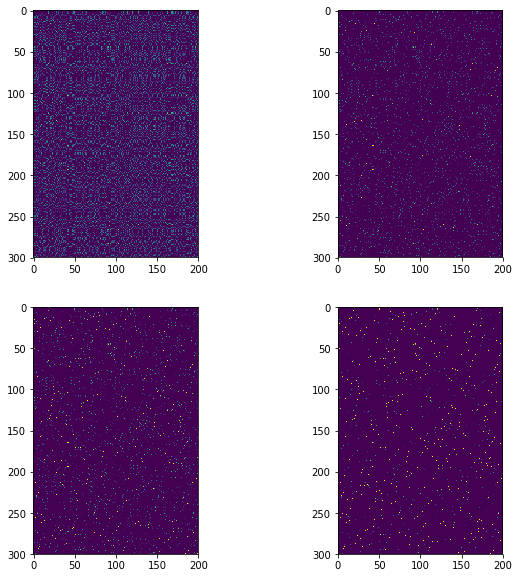

In [21]:
run -i solutions/exo2

Compute the obtained optimal $P$.

In [22]:
P = sinkhorns[0].P #np.dot(np.dot(np.diag(u),K),np.diag(v))

Keep only the highest entries of the coupling matrix, and use them to
draw a map between the two clouds.
First we draw "strong" connexions, i.e. linkds $(i,j)$ corresponding to
large values of $P_{i,j}$.
We then draw weaker connexions.

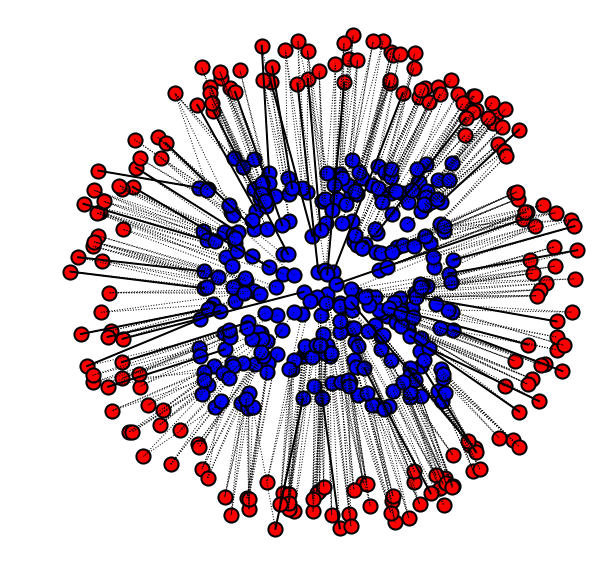

In [23]:
plt.figure(figsize=(10,10))

plotp(x, 'b')
plotp(y, 'r')

A = P * (P > np.max(P)*.8)
i,j = np.where(A != 0)
plt.plot([x[0,i],y[0,j]],[x[1,i],y[1,j]],'k',lw = 2)

A = P * (P > np.max(P)*.2)
i,j = np.where(A != 0)
plt.plot([x[0,i],y[0,j]],[x[1,i],y[1,j]],'k:',lw = 1)

plt.axis("off")
plt.xlim(np.min(y[0,:])-.1,np.max(y[0,:])+.1)
plt.ylim(np.min(y[1,:])-.1,np.max(y[1,:])+.1)

plt.show()

II. Transport Between Histograms
----------------------------
We now consider a different setup, where the histogram values
$a,b$ are not uniform, but the measures are defined on a uniform grid
$x_i=y_i=i/n$. They are thus often refered to as "histograms".


Size $n$ of the histograms.

In [24]:
N = 200

We use here a 1-D square Euclidean metric. Note that this exemple is just for demonstration purpose as there are closed form solutions to OT in 1-D.

In [25]:
t = np.arange(0,N)/N

Define the histogram $a,b$ as translated Gaussians.

In [26]:
Gaussian = lambda t0,sigma: np.exp(-(t-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)

sigma = .06;
a = Gaussian(.25,sigma)
b = Gaussian(.8,sigma)

Add some minimal mass and normalize.

In [27]:
vmin = .02;
a = normalize( a+np.max(a)*vmin)
b = normalize( b+np.max(b)*vmin)

Display the histograms.

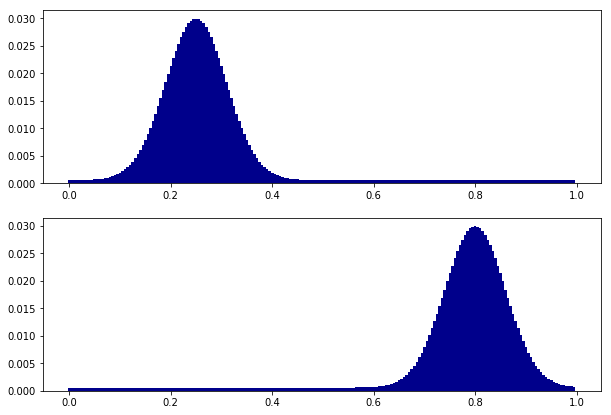

In [28]:
plt.figure(figsize = (10,7))

plt.subplot(2, 1, 1)
plt.bar(t, a, width = 1/len(t), color = "darkblue")
plt.subplot(2, 1, 2)
plt.bar(t, b, width = 1/len(t), color = "darkblue")

plt.show()

Regularization strength $\ga$.

In [29]:
epsilon = (.03)**2

The Gibbs kernel is a Gaussian convolution,
$$ K_{i,j} \eqdef e^{ -(i/N-j/N)^2/\epsilon }. $$

In [30]:
[Y,X] = np.meshgrid(t,t)
K = np.exp(-(X-Y)**2/epsilon)

Initialization of $v=\ones_{N}$.

In [31]:
v = np.ones(N)

One sinkhorn iteration.

In [32]:
u = a / (np.dot(K,v))
v = b / (np.dot(np.transpose(K),u))

__Exercise 3__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$ \norm{ P \ones - a }_1, \norm{ P^\top \ones - b }_1$. You need to think how to compute it from $(u,v)$.
Display the violation of constraint error in log-plot.

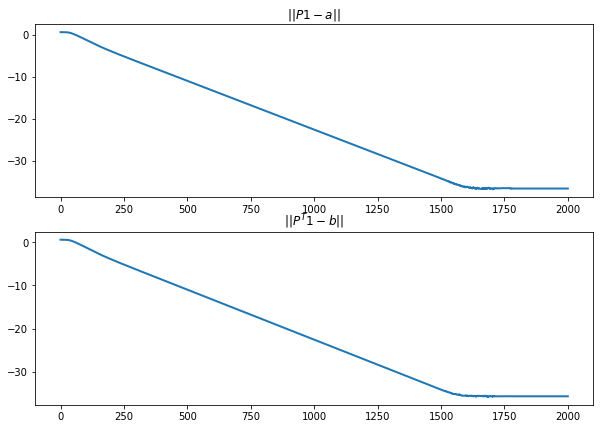

In [33]:
sinkhorn_hist = Sinkhorn(K, a, b, max_it=2000)
sinkhorn_hist.solve()

plt.figure(figsize = (10,7))

plt.subplot(2,1,1)
plt.title("$||P 1 - a||$")
plt.plot(np.log(np.asarray(sinkhorn_hist.a_err)), linewidth = 2)

plt.subplot(2,1,2)
plt.title("$||P^T 1 - b||$")
plt.plot(np.log(np.asarray(sinkhorn_hist.b_err)), linewidth = 2)

plt.show()

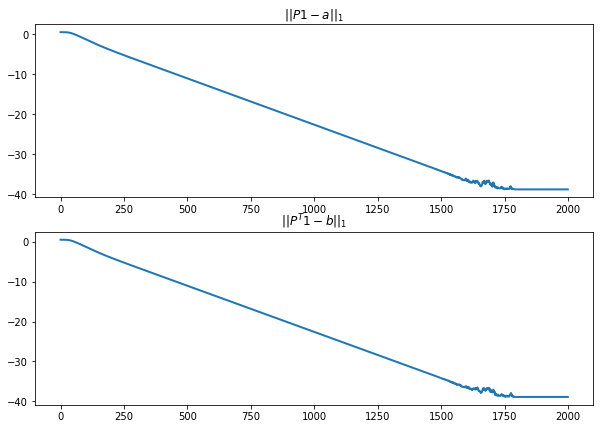

<Figure size 432x288 with 0 Axes>

In [34]:
run -i solutions/exo3

Display the coupling. Use a log domain plot to better vizualize it.

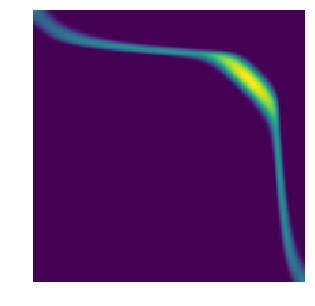

In [35]:
P = sinkhorn_hist.P # np.dot(np.dot(np.diag(u),K),np.diag(v))
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.axis('off');

One can compute an approximation of the transport plan
between the two measure by computing the so-called barycentric projection map
$$ t_i \in [0,1] \longmapsto s_j \eqdef \frac{\sum_{j} P_{i,j} t_j }{ \sum_{j} P_{i,j} }
   =  \frac{ [u \odot K(v \odot t)]_j }{ a_i }. $$
where $\odot$ and $\frac{\cdot}{\cdot}$ are the enry-wise multiplication and division.


This computation can thus be done using only multiplication with the
kernel $K$.

In [36]:
s = np.dot(K,sinkhorn_hist.v*t)*sinkhorn_hist.u/a

Display the transport map, super-imposed over the coupling.

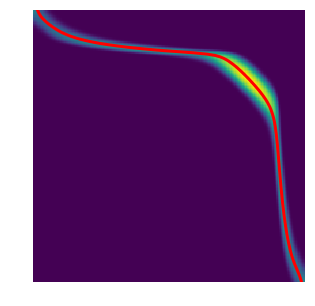

In [37]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.plot(s*N,t*N, 'r', linewidth=3);
plt.axis('off');

__Exercise (bonus)__

Try different regularization strength $\epsilon$.

#### Unbalanced Optimal Transport
There exists extensions of optimal transport that allow to deal with unnormalized histograms (i.e. that do not necessarily sum to $1$). In one of its forms, unbalanced OT with entropic regularization solves the problem:
$$
\min_{P_{ij}>0} \lambda KL(P\ones_m |a) + \lambda KL(P^T\ones_n | b) + \epsilon KL(P|K).
$$
Sinkhorn's algorithm can be extended to this case using the following iterates: $v \longleftarrow \ones_m$ and
$$u \longleftarrow \left(\frac{a}{K v}\right)^{\lambda/(\lambda+\epsilon)} \qandq v \longleftarrow \left(\frac{b}{K^\top u}\right)^{\lambda/(\lambda+\epsilon)} .$$
The parameter $\lambda$ determines how much we would like the marginals of $P$ to resemble $a$ and $b$. When $a$ and $b$ have the same mass, $P$ converges to a classical optimal transport plan as $\lambda$ goes to $\infty$. More on the theory of unbalanced optimal transport and on these generalized Sinkhorn's algorithm can be found in [Chizat](#biblio).

__Exercise 3 bis__

Implement unbalanced optimal transport for the 1-D transport between two Gaussians. Observe how the marginals of the solution $P$ differ from $a$ and $b$, and how this depends on $\lambda$.

Define the histogram $a,b$ as translated Gaussians.

In [38]:
sigma = .06;
a = Gaussian(.25,sigma)
b = Gaussian(.8,sigma)

vmin = .02;
a = a+np.max(a)*vmin
b = b+np.max(b)*vmin

Display the histograms.

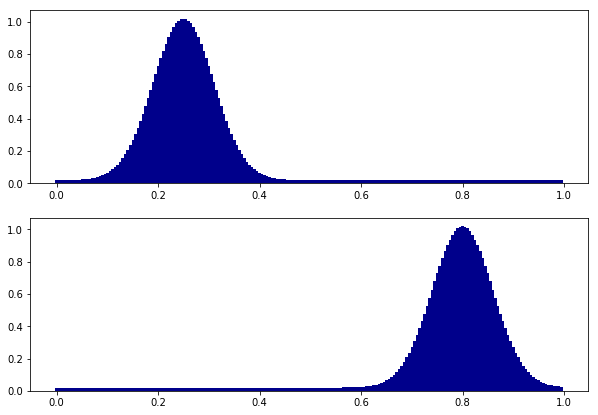

In [39]:
plt.figure(figsize = (10,7))

plt.subplot(2, 1, 1)
plt.bar(t, a, width = 1/len(t), color = "darkblue")
plt.subplot(2, 1, 2)
plt.bar(t, b, width = 1/len(t), color = "darkblue")

plt.show()

In [40]:
class Sinkhorn_unbalanced:
    
    def __init__(self, K, a, b, lbda, epsilon, max_it=1000):
        self.K = K
        self.a = a
        self.b = b
        self.lbda = lbda
        self.epsilon = epsilon
        self.max_it = max_it
        self.v = np.ones(len(b))
        self.u = None
        self.a_err = []
        self.b_err = []
        
    def solve(self):
        conv = False
        it = 0
        while not conv:
            # step 1
            u_np1 = (self.a / (np.dot(self.K, self.v)))**(self.lbda/(self.lbda+self.epsilon))
            P = np.diag(u_np1).dot(self.K.dot(np.diag(self.v)))
            self.b_err.append(np.sum( np.abs( np.sum(P, axis=0) - self.b ) ))
            # step 2
            v_np1 = (self.b / (np.dot(np.transpose(self.K),u_np1)))**(self.lbda/(self.lbda+self.epsilon))
            P = np.diag(u_np1).dot(self.K.dot(np.diag(v_np1)))
            self.a_err.append(np.sum( np.abs( np.sum(P, axis=1) - self.a ) ))
            # total updates
            self.u, self.v = u_np1, v_np1
            it += 1
            conv = (it>self.max_it)
        self.P = P

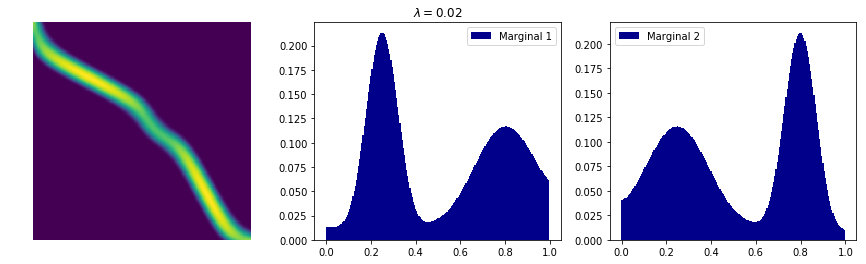

In [44]:
lbda = 0.02

sinkhorn_unbalanced = Sinkhorn_unbalanced(K, a, b, lbda=lbda, epsilon=epsilon, max_it=200)
sinkhorn_unbalanced.solve()

plt.figure(figsize = (15,4))

plt.subplot(1,3,1)
plt.imshow(np.log(sinkhorn_unbalanced.P+1e-5))
plt.axis('off');

plt.subplot(1,3,2)
plt.bar(t, np.sum(sinkhorn_unbalanced.P, axis=1), width = 1/len(t), color = "darkblue", label="Marginal 1")
plt.title("$\lambda = ${}".format(lbda))
plt.legend()

plt.subplot(1,3,3)
plt.bar(t, np.sum(sinkhorn_unbalanced.P, axis=0), width = 1/len(t), color = "darkblue", label="Marginal 2")
plt.legend()

plt.show()

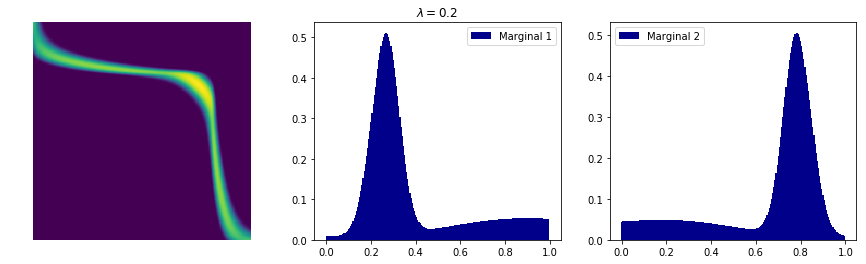

In [45]:
lbda = 0.2

sinkhorn_unbalanced = Sinkhorn_unbalanced(K, a, b, lbda=lbda, epsilon=epsilon, max_it=200)
sinkhorn_unbalanced.solve()

plt.figure(figsize = (15,4))

plt.subplot(1,3,1)
plt.imshow(np.log(sinkhorn_unbalanced.P+1e-5))
plt.axis('off');

plt.subplot(1,3,2)
plt.bar(t, np.sum(sinkhorn_unbalanced.P, axis=1), width = 1/len(t), color = "darkblue", label="Marginal 1")
plt.title("$\lambda = ${}".format(lbda))
plt.legend()

plt.subplot(1,3,3)
plt.bar(t, np.sum(sinkhorn_unbalanced.P, axis=0), width = 1/len(t), color = "darkblue", label="Marginal 2")
plt.legend()

plt.show()

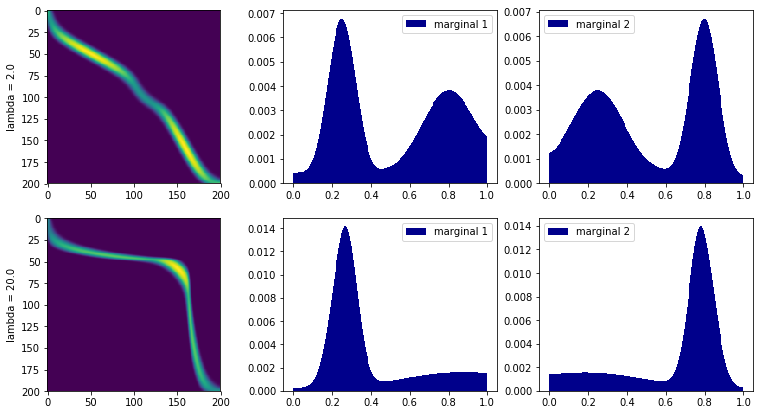

In [33]:
run -i solutions/exo3_bis

III. Wasserstein Barycenters
-----------------------
Instead of computing transport, we now turn to the problem of computing
barycenter of $R$ input measures $(a_k)_{k=1}^R$. A barycenter $b$ solves
$$ \umin{b} \sum_{k=1}^R W_\ga(a_k,b)  $$
where $\la_k$ are positive weights with $\sum_k \la_k=1$. This
follows the definition of barycenters proposed in
[AguehCarlier](#biblio).

Dimension (width of the images) $N$ of the histograms.

In [46]:
N = 70

You need to install imageio, for instance using
> conda install -c conda-forge imageio

If you need to rescale the image size, you can use
> skimage.transform.resize

In [47]:
import imageio

Load input histograms $(a_k)_{k=1}^R$, store them in a tensor $A$.

In [48]:
rescale = lambda x: (x-x.min())/(x.max()-x.min())
names = ['disk','twodisks','letter-x','letter-z']
vmin = .01
A = np.zeros([N,N,len(names)])
for i in range(len(names)):
    a = imageio.imread("data/" + names[i] + ".bmp") # ,N) 
    a = normalize(rescale(a)+vmin)
    A[:,:,i] = a
R = len(names)

Display the input histograms.

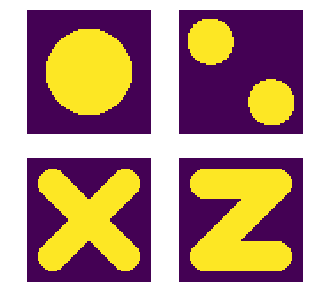

In [49]:
plt.figure(figsize=(5,5))
for i in range(R):
    plt.subplot(2,2,i+1)
    plt.imshow(A[:,:,i])
    plt.axis('off');

In this specific case, the kernel $K$ associated with the
squared Euclidean norm is a convolution with a Gaussian filter
$$ K_{i,j} = e^{ -\norm{i/N-j/N}^2/\epsilon } $$
where here $(i,j)$ are 2-D indexes.


The multiplication against the kernel, i.e. $K(a)$, 
can now be computed efficiently, using fast convolution methods. 
This crucial points was exploited and generalized in [SolomonEtAl](#biblio)
to design fast optimal transport algorithm.

Regularization strength $\epsilon>0$.

In [38]:
epsilon = (.04)**2

Define the $K$ kernel.
We use here the fact that the convolution is separable to implement it
using only 1-D convolution, which further speeds up computations.

In [39]:
t = np.linspace(0,1,N)
[Y,X] = np.meshgrid(t,t)
K1 = np.exp(-(X-Y)**2/epsilon)
K = lambda x: np.dot(np.dot(K1,x),K1)

Display the application of the $K$ kernel on one of the input histogram.

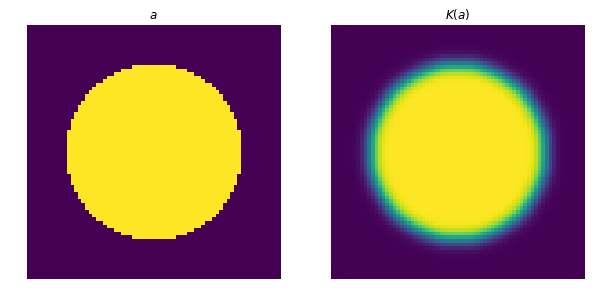

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(A[:,:,0])
plt.title("$a$")
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(K(A[:,:,0]))
plt.title("$K(a)$")
plt.axis('off');

Weights $\la_k$ for isobarycenter.

In [41]:
lambd = np.ones(R)/R

It is shown in [BenamouEtAl](#biblio) that the problem of Barycenter computation
boilds down to
optimizing over couplings $(P_k)_{k=1}^R$, and that this can be achieved
using iterative a Sinkhorn-like algorithm, since the optimal coupling has the scaling form
$$P_k = \diag{u_k} K \diag{v_k}$$
for some unknown positive weights $(u_k,v_k)$.

Initialize the scaling factors $(u_k,v_k)_k$, store them in matrices.

In [42]:
v = np.ones([N,N,R])
u = np.copy(v)

The first step of the Bregman projection method corresponds to the
projection on the fixed marginals constraints $P^k \ones = a_k$. This
is achieved by updating
$$ \forall k=1,\ldots,R, \quad u_k \longleftarrow \frac{a_k}{ K( v_k ) }. $$

In [43]:
for k in range(R):
    u[:,:,k] = A[:,:,k]/K(v[:,:,k])

The second step of the Bregman projection method corresponds to the
projection on the equal marginals constraints $\forall k, P_k^\top \ones=b$ for a common barycenter target $b$. This
is achieved by first computing the target barycenter $b$ using a geometric means
$$ \log(b) \eqdef \sum_k \lambda_k \log( u_{k} \odot K ( v_{k} ) ). $$

In [44]:
b = np.zeros(N)
for k in range(R):
    b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
b = np.exp(b)

Display $b$.

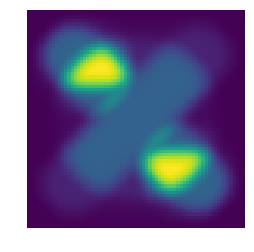

In [45]:
plt.imshow(b);
plt.axis('off');

And then one can update the scaling by a Sinkhorn step using this newly computed histogram $b$ as follow (note that $K=K^\top$ here):
$$ \forall k=1,\ldots,R, \quad v_{k} \longleftarrow \frac{b}{ K(u_{k}) }. $$

In [46]:
for k in range(R):
    v[:,:,k] = b/K(u[:,:,k])

__Exercise 4__

Implement the iterative algorithm to compute the iso-barycenter of the measures.
Plot the decay of the error $\sum_k \norm{P_k \ones - a_k} $.

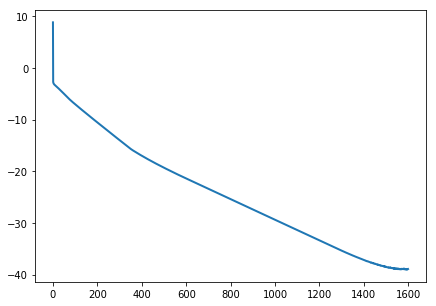

<Figure size 432x288 with 0 Axes>

In [47]:
run -i solutions/exo4

Display the barycenter.

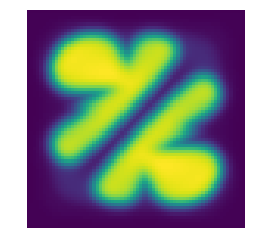

In [48]:
plt.imshow(b)
plt.axis('off');

__Exercise 5__

Compute barycenters for varying weights $\la$ corresponding to
a bilinear interpolation inside a square.

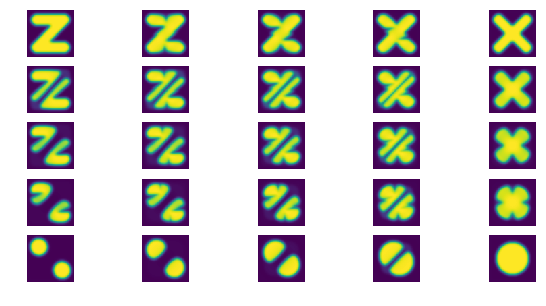

In [49]:
run -i solutions/exo5 # takes around 20 seconds

IV. Stabilization and Acceleration
-----------------------
We now come back to the most simple version of Sinkhorn's algorithm that we have implemented in Exercise 1. We will see how to stabilize this algorithm to avoid numerical errors and how to accelerate convergence. The latter is an active subject of research, see e.g. [Schmitzer](#biblio) for a list of tricks. These ideas are implemented in [Bernhard Schmitzer's package](https://github.com/bernhard-schmitzer/optimal-transport/tree/master/v0.2.0) and in the recent [GeomLoss Python Package](https://www.kernel-operations.io/geomloss/) (where it is combined with computations on GPUs). 

This section is more advanced, so make sure that you are confortable with the previous sections before proceeding.

### Stabilizing with dual iterates

In the previous experiments, while using Sinkhorn updates:
$$u \longleftarrow \frac{a}{K v} \qandq v \longleftarrow \frac{b}{K^\top u},$$
you may have noticed that taking a small regularization parameter $\epsilon$ leads to numerical instabilities, because of the exponential terms. This issue might be alleviated by considering the variables $f = \epsilon \log(u/a)$ and $g = \epsilon \log(v/b)$. In these variables, Sinkhorn algorithm can be interpreted as an alternate maximization algorithm, to solve the following "dual" problem:
$$
\max_{f\in R^n, g \in R^m} F(f,g) =  \sum_{i=1}^n f_i a_i + \sum_{j=1}^m g_j b_j - \epsilon \sum_{i,j} a_ib_j \exp \left( (f_i + g_j -C_{ij})/\epsilon \right).
$$

In these variables, the algorithm is initialized with $g = 0_m$ and the updates read
$$
f_i \longleftarrow - \epsilon \log \sum_{j} b_j \exp ((g_j - C_{ij})/\epsilon),\, \forall i \\
g_j \longleftarrow - \epsilon \log \sum_{i} a_i \exp ((f_i - C_{ij})/\epsilon),\, \forall j
$$

__Exercise (optional)__ You can check, using first order optimality conditions, that each of these updates correspond to maximizing the dual objective while fixing either $f$ or $g$.

These updates still involve the exponential of potentially large numbers, but followed by a sum and a logarithm. This operation (known as log-sum-exp or softmax), can be stabilized by factorizing out the maximum of the sum, i.e. replacing $\log\sum_j \exp(z_j)$ by $\bar z + \log\sum_j \exp(z_j-\bar z)$ where $\bar z = \max_j z_j$. This guarantees that the all exponential terms involved are smaller than $1$.

Generate data (as in exercise 1). The ideas seen in the rest of the notebook can be as well applied to the computation of barycenters and other problems related to optimal transport, but we will use the basic optimal transport problem as our test case.

In [50]:
N = [300,200]
d = 2
x = np.random.rand(2,N[0])-.5
theta = 2*np.pi*np.random.rand(1,N[1])
r = .8 + .2*np.random.rand(1,N[1])
y = np.vstack((np.cos(theta)*r,np.sin(theta)*r))
C = (x[0,:].reshape(-1,1) - y[0,:].reshape(1,-1))**2 + (x[1,:].reshape(-1,1) - y[1,:].reshape(1,-1))**2
a = np.ones(N[0])/N[0]
b = np.ones(N[1])/N[1]

Define the regularization parameter.

In [51]:
epsilon = 0.1

Initialize $g$ with 0.

In [52]:
g = np.zeros(N[1])

Execute one stable update to obtain the next iterate of $f$.

In [53]:
Mf = g.reshape(1,-1) - C
Mf_max = np.max(Mf, axis = 1)
f = - Mf_max - epsilon*np.log(np.sum( b.reshape(1,-1) * np.exp((Mf - Mf_max.reshape(-1,1))/epsilon), axis=1))

__Exercise 6__

Implement stabilized Sinkhorn's algorithm. Display the convergence of the dual objective $F$ which expression is given above (display the suboptimality gap in log-scale). Display also the evolution of the constraints satisfaction errors $ \norm{ P \ones - a }_1$. Observe the behavior of the algorithm as $\epsilon$ gets smaller. 

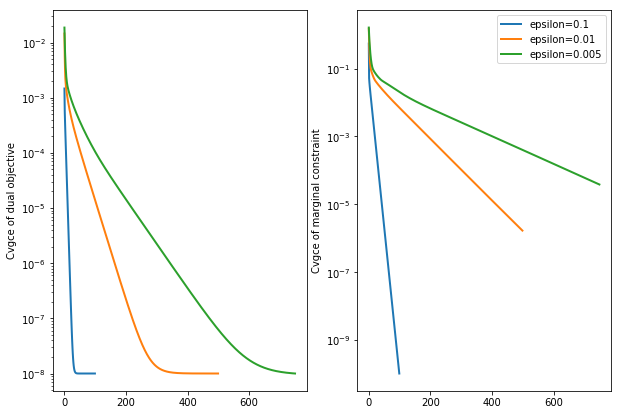

In [54]:
run -i solutions/exo6

The optimal transport plan $P=(P_{ij})_{\substack{i=1\dots n\\j=1\dots m}}$ can be recovered as 
$$
P_{ij} = a_ib_j\exp\left( (f_i+g_j - C_{ij})/\epsilon \right).
$$

## Acceleration methods

There exists plenty of ways to accelerate the convergence of Sinkhorn's algorithm and it is an active field of research. In this notebook, we will review some approaches that can be quickly implemented.

### Acceleration with over-relaxation
A classical way to accelerate the convergence of fixed-point algorithms is through over-relaxation. It consists in replacing the update by a linear combination of the new and previous iterate. With an over-relaxation parameter $\tau \in ]0,1]$, the algorithm becomes:
$$
f \longleftarrow (1+\tau)*\bar f - \tau f \quad \text{where} \quad \bar f_i = - \epsilon \log \sum_{j} b_j \exp ((g_j - C_{ij})/\epsilon),\, \forall i \\
g \longleftarrow (1+\tau)*\bar g - \tau g \quad \text{where} \quad \bar g_j = - \epsilon \log \sum_{i} a_i \exp ((f_i - C_{ij})/\epsilon),\, \forall j
$$
This over-relaxation method was analyzed theoretically for regularized OT in [ThibaultEtAl](#biblio).

__Exercise 7__

Implement the overrelaxed Sinkhorn's algorithm in the log domain to solve the problem of Exercise 1. Observe the behavior as $\tau$ varies. 

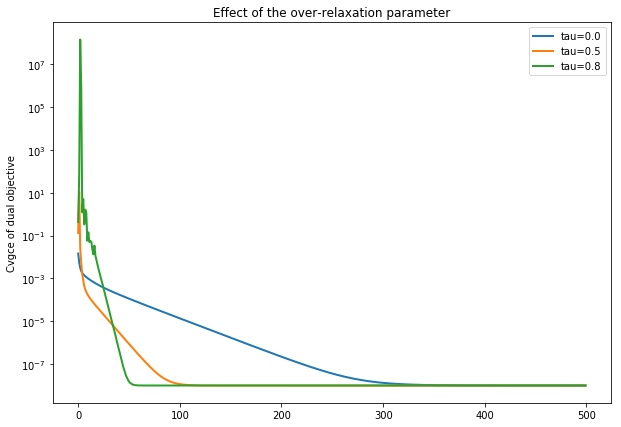

In [55]:
run -i solutions/exo7

This over-relaxation leads to faster convergence when $\tau$ is well chosen, but it becomes unstable as $\tau$ gets closer to $1$ (the algorithm can even diverge). There exists more advanced acceleration methods that automatically tune the over-parameterization parameter and that may take a linear combination of more than two successive iterates. We will see in the last exercise one of the most advanced such methods.

### Acceleration with simulated annealing

Another idea to converge faster is to start with a large value of $\epsilon$ and decrease it successively, for instance by multiplying it by a factor smaller than $1$ at each iteration. This idea is standard in optimization and was proposed for regularized OT in [KosowskyYuille](#biblio).

__Exercise 8__

Implement Sinkhorn algorithm with simulated annealing, using a regularization parameter at iteration $l$ of the form:
$$
\epsilon(l) = \max \left\{\epsilon_{end}, \epsilon_{init}*\beta^{l}\right\}
$$
where $ 0 <\beta <1$ is a parameter. Observe the convergence of the dual objective $F$ (computed with $\epsilon_{end}$) for various annealing schedules (i.e. choices of $\epsilon_{init} \geq \epsilon_{end}$ and $\beta$.

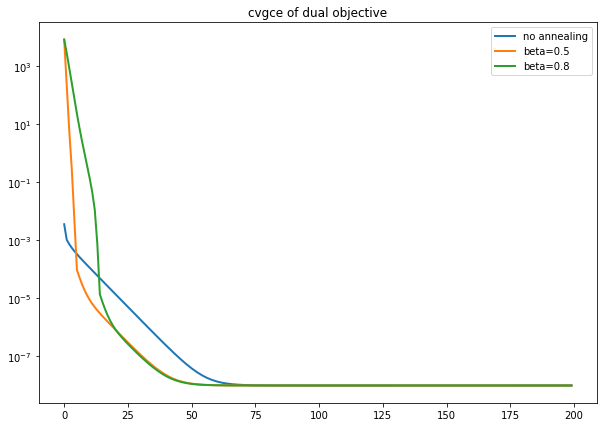

In [56]:
run -i solutions/exo8

We observe that this strategy allows to reach approximate solutions slightly faster. This approach is efficient if the problem has an intrinsic "multiscale" structure, but performs poorly if the cost matrix has no structure. For detailed comments on how to set the annealing schedule, see e.g. [Schmitzer](#biblio) or [GeomLoss Documentation](https://www.kernel-operations.io/geomloss/_auto_examples/sinkhorn_multiscale/plot_epsilon_scaling.html#sphx-glr-auto-examples-sinkhorn-multiscale-plot-epsilon-scaling-py).

### Acceleration with Regularized non-linear acceleration (RNA)

Regularized non-linear acceleration (RNA) is a general method to accelerate any fixed point algorithm. Call $T$ the application that maps $g$ to its update after one iteration. Choose $\lambda>0$ a small regularization parameter and $k$ the order of the method (the number of successive iterates that are linearly combined, typically between 3 and 10).
- (i) Generate $k$ pairs $(g_l,T(g_l))$ by running $k$ iterations of the algorithm
- (ii) Define a $m\times k$ matrix of residues $R = [T(g_{l-k+1})-g_{l-k+1},\dots,T(g_l)-g_l]$
- (iii) Solve the linear system $z = (R^TR + \lambda I)^{-1}\ones_k$
- (iv) Normalize the solution $c = z/\sum_{i=1}^k z_i$
- (v) Replace the next iterate by $g_{l+1} = \sum_{i=1}^k c_i T(g_{l-k + i})$
- (vi) Compute $T(g_{l+1})$ and go back to (ii) after removing the oldest pair $(g_{l-k+1},T(g_{l-k+1}))$ and adding the new one $(g_{l+1},T(g_{l+1}))$. Set $l \leftarrow l+1$.

This computation of the coefficients $c_i$ is implemented in the following function.

In [57]:
def RNA_coeffs(R,la):
    "Return the next iterate given the matrix of residuals R and regularization parameter la>0"
    K = np.matmul(R.transpose(),R)
    k = np.shape(R)[1]
    nK = np.linalg.norm(K)
    if nK > 0.0:
        K = K/nK
    z = np.linalg.solve(K + la*np.eye(k), np.ones(k))
    return z/np.sum(z)

__Exercise 9__ : Implement RNA for Sinkhorn's algorithm (in the stable log implementation).

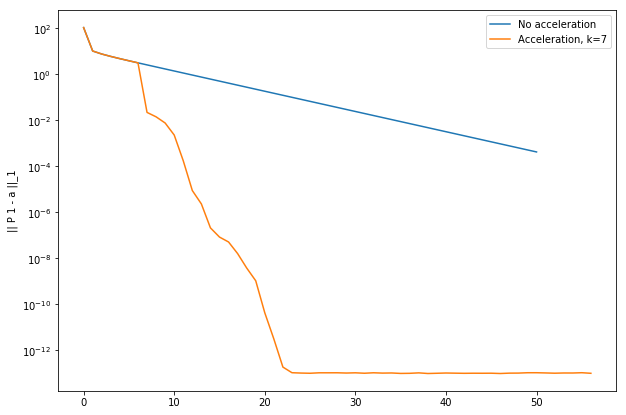

In [58]:
run -i solutions/exo9

This acceleration method tends to be stable (if $\lambda$ is not too small) and very efficient. It is studied in details in [Scieur](#biblio).

Bibliography
------------
<html><a name="biblio"></a></html>


* [Villani] C. Villani, (2009). Optimal transport: old and new, volume 338. Springer Verlag.
* [Cuturi] M. Cuturi, (2013). Sinkhorn distances: Lightspeed computation of optimal transport. In Burges, C. J. C., Bottou, L., Ghahramani, Z., and Weinberger, K. Q., editors, Proc. NIPS, pages 2292-2300.
* [AguehCarlier] M. Agueh, and G Carlier, (2011). Barycenters in the Wasserstein space. SIAM J. on Mathematical Analysis, 43(2):904-924.
* [CuturiDoucet] M. Cuturi and A. Doucet (2014). Fast computation of wasserstein barycenters. In Proc. ICML.
* [BauschkeLewis] H. H. Bauschke and A. S. Lewis. Dykstra's algorithm with Bregman projections: a convergence proof. Optimization, 48(4):409-427, 2000.
* [Sinkhorn] R. Sinkhorn. A relationship between arbitrary positive matrices and doubly stochastic matrices. Ann. Math. Statist., 35:876-879, 1964.
* [SolomonEtAl] J. Solomon, F. de Goes, G. Peyr , M. Cuturi, A. Butscher, A. Nguyen, T. Du, and L. Guibas. Convolutional Wasserstein distances: Efficient optimal transportation on geometric domains. Transaction on Graphics, Proc. SIGGRAPH, 2015.
* [BenamouEtAl] J-D. Benamou, G. Carlier, M. Cuturi, L. Nenna, G. Peyr . Iterative Bregman Projections for Regularized Transportation Problems. SIAM Journal on Scientific Computing, 37(2), pp. A1111-A1138, 2015.
* [Schmitzer]  B. Schmitzer. Stabilized Sparse Scaling Algorithms for Entropy Regularized Transport Problems. SIAM Journal on Scientific Computing, 41(3), A1443–A1481, 2019. 
* [ThibaultEtAl]  A. Thibault, L. Chizat, C. Dossal, N. Papadakis. Overrelaxed sinkhorn-knopp algorithm for regularized optimal transport. arXiv:1711.01851, 2017.
* [KosowskyYuille] J. Kosowsky, A. Yuille. The invisible hand algorithm: Solving the assignment problem with statistical physics. Neural networks 7.3, 477-490 (1994).
* [Scieur] D. Scieur. Acceleration in Optimization, PSL Research University (2018).
* [Chizat] L. Chizat. Unbalanced Optimal Transport: Models, Numerical Methods, Applications, PSL Research University (2017).